# 1. Setup
Download necessary dependencies


In [1]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# load a model pre-trained pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:04<00:00, 38.5MB/s]


We download the training data (~1G) and unizp it.




In [0]:
%%shell
wget --save-cookies cookies.txt 'https://docs.google.com/uc?export=download&id=1gbeiBOJbtzxbehxsgERpKkQcAjIO3EAF' -O- \ | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1/p' > confirm.txt
wget --load-cookies cookies.txt -O images.zip \
     'https://docs.google.com/uc?export=download&id=1gbeiBOJbtzxbehxsgERpKkQcAjIO3EAF&confirm='$(<confirm.txt)

In [0]:
!unzip images -q

In [0]:
%%shell

# Install pycocotools for accuracy metrics
git clone https://github.com/cocodataset/cocoapi.git
cd cocoapi/PythonAPI
python setup.py build_ext install

In [0]:
%%shell

# Download TorchVision repo to util some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.3.0

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

We ensure that the cleaned lables are present and correct

In [6]:
import pandas as pd
test_frame = pd.read_csv('images/test/cleaned_test_labels.csv')

got = pd.read_csv('images/train/cleaned_train_labels.csv')
print(got)

                                  filename  width  ...  xmax.4 ymax.4
0      CARDS_LIVINGROOM_T_B_frame_0225.jpg   1280  ...     NaN    NaN
1      JENGA_LIVINGROOM_H_B_frame_0079.jpg   1280  ...     NaN    NaN
2      PUZZLE_COURTYARD_B_S_frame_0757.jpg   1280  ...     NaN    NaN
3          CHESS_OFFICE_H_T_frame_0735.jpg   1280  ...     NaN    NaN
4      PUZZLE_COURTYARD_B_S_frame_0363.jpg   1280  ...     NaN    NaN
...                                    ...    ...  ...     ...    ...
4378    JENGA_COURTYARD_B_H_frame_0708.jpg   1280  ...     NaN    NaN
4379  PUZZLE_LIVINGROOM_H_S_frame_1294.jpg   1280  ...     NaN    NaN
4380   CHESS_LIVINGROOM_S_B_frame_0635.jpg   1280  ...     NaN    NaN
4381  PUZZLE_LIVINGROOM_T_B_frame_1782.jpg   1280  ...     NaN    NaN
4382    CARDS_COURTYARD_B_T_frame_1812.jpg   1280  ...     NaN    NaN

[4383 rows x 24 columns]


In [0]:
def show_boxes(image, boxes, transpose=True):
    """Show image with boxes"""
    im = plt.imshow(np.transpose(image, (1, 2, 0)) if transpose else image)
    ax = plt.gca()
    for box in boxes:
        h = box[3] - box[1]
        w = box[2] - box[0]
        rect = patches.Rectangle(
            (box[0], box[1]), w, h, linewidth=1, edgecolor="r", facecolor="none"
        )
        ax.add_patch(rect)
    plt.pause(0.002)  # pause a bit so that plots are updated
    
    return im


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  del sys.path[0]


(4, 4)
[[179. 674. 338. 718.]
 [577. 695. 715. 718.]
 [666. 214. 819. 345.]
 [281. 174. 461. 341.]]


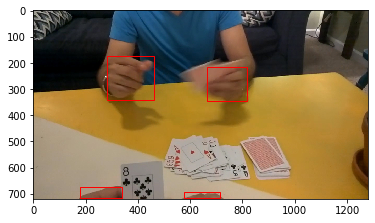

In [8]:
%matplotlib inline
import matplotlib.patches as patches
from skimage import io 
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import os

n = 35
img_name = test_frame.iloc[n, 0]
boxes = test_frame.iloc[n, 4:].as_matrix()
boxes = boxes.astype('float')
boxes = boxes[~np.isnan(boxes)]
boxes = boxes.reshape(-1, 4)
print(boxes.shape)
print(boxes)
image = io.imread(os.path.join('images/test', img_name))
show_boxes(image, boxes, False)

# 2. Create the dataset and classifier

In [0]:
class EgoHandsDataset(Dataset):
    """EgoHands dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.landmarks_frame = pd.read_csv(os.path.join(root_dir, csv_file))
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.landmarks_frame.iloc[idx, 0])
        image = io.imread(img_name)
        
        boxes = self.landmarks_frame.iloc[idx, 4:].as_matrix()
        num_objs = (len(boxes))//4
        boxes = boxes.astype('float')
        boxes = boxes[~np.isnan(boxes)]
        boxes = boxes.reshape(-1, 4)
        labels = torch.ones(len(boxes), dtype=torch.int64)
        targets = { 'boxes': torch.Tensor(boxes), 'labels': labels}
        image_id = torch.tensor([idx])

        # we initialize dummy data for pycoco metrics
        # these can be replaced later on if pycoco metrics need to be used
        targets["image_id"] = image_id
        targets["area"] = torch.zeros((num_objs,), dtype=torch.float32)
        targets["iscrowd"] = torch.zeros((num_objs,), dtype=torch.int64)
        if self.transform:
            image, targets = self.transform(image, targets)
        targets["masks"] = torch.zeros_like(image, dtype=torch.uint8)
        return image, targets

In [0]:
import transforms as T

def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [0]:
# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = 2  # 1 class (hand) + background
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

We test the pretrained model with the new untrained predictor

203


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


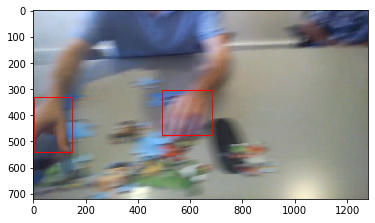

tensor([0.6144, 0.5903, 0.5749, 0.5592, 0.5567, 0.5413, 0.5399, 0.5363, 0.5358,
        0.5334, 0.5330, 0.5243, 0.5238, 0.5120, 0.5057, 0.5023, 0.5017, 0.5009,
        0.4987, 0.4982, 0.4961, 0.4958, 0.4939, 0.4924, 0.4873, 0.4850, 0.4826,
        0.4813, 0.4714, 0.4693, 0.4664, 0.4634, 0.4605, 0.4599, 0.4515, 0.4504,
        0.4486, 0.4455, 0.4434, 0.4424, 0.4420, 0.4406, 0.4404, 0.4395, 0.4375,
        0.4374, 0.4369, 0.4360, 0.4347, 0.4342, 0.4331, 0.4313, 0.4278, 0.4273,
        0.4268, 0.4266, 0.4256, 0.4250, 0.4238, 0.4214, 0.4214, 0.4193, 0.4186,
        0.4148, 0.4132, 0.4123, 0.4105, 0.4078, 0.4072, 0.4068, 0.4067, 0.4066,
        0.4054, 0.4048, 0.4042, 0.4019, 0.4009, 0.4004, 0.4004, 0.3991, 0.3979,
        0.3976, 0.3955, 0.3941, 0.3937, 0.3936, 0.3932, 0.3932, 0.3930, 0.3929,
        0.3917, 0.3914, 0.3910, 0.3905, 0.3896, 0.3894, 0.3893, 0.3890, 0.3877,
        0.3872], device='cuda:0', grad_fn=<IndexBackward>)


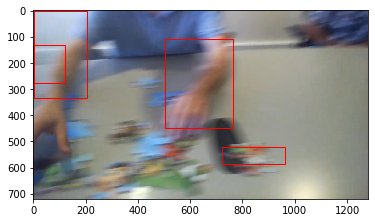

In [12]:
from random import randrange
test_dataset = EgoHandsDataset("cleaned_test_labels.csv", "images/test",transform=get_transform(train=False))
train_dataset = EgoHandsDataset("cleaned_train_labels.csv", "images/train", transform=get_transform(train=True))
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

n = randrange(0,400)
print(n)
image,target = test_dataset[n]
#print(target)
show_boxes(image, target['boxes'])
images= torch.stack([image]).cuda()
#print(target)
model.eval()
model = model.cuda()
out = model(images)
print(out[0]['scores'])
show_boxes(image, out[0]['boxes'][0:4])


# 3. Create Dataloaders, IoU accuracy metric, and train

In [0]:
import utils
data_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=2, shuffle=True, collate_fn=utils.collate_fn, num_workers=4)
data_loader_test = torch.utils.data.DataLoader(
    test_dataset, batch_size=2, shuffle=False, collate_fn=utils.collate_fn, num_workers=4)
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)



# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)



In [0]:
# from https://github.com/amdegroot/ssd.pytorch/blob/master/layers/box_utils.py
# MIT License

# Copyright (c) 2017 Max deGroot, Ellis Brown
import torch


def intersect(box_a, box_b):
    """ We resize both tensors to [A,B,2] without new malloc:
    [A,2] -> [A,1,2] -> [A,B,2]
    [B,2] -> [1,B,2] -> [A,B,2]
    Then we compute the area of intersect between box_a and box_b.
    Args:
      box_a: (tensor) bounding boxes, Shape: [A,4].
      box_b: (tensor) bounding boxes, Shape: [B,4].
    Return:
      (tensor) intersection area, Shape: [A,B].
    """
    A = box_a.size(0)
    B = box_b.size(0)
    max_xy = torch.min(box_a[:, 2:].unsqueeze(1).expand(A, B, 2),
                       box_b[:, 2:].unsqueeze(0).expand(A, B, 2))
    min_xy = torch.max(box_a[:, :2].unsqueeze(1).expand(A, B, 2),
                       box_b[:, :2].unsqueeze(0).expand(A, B, 2))
    inter = torch.clamp((max_xy - min_xy), min=0)
    return inter[:, :, 0] * inter[:, :, 1]


def jaccard(box_a, box_b):
    """Compute the jaccard overlap of two sets of boxes.  The jaccard overlap
    is simply the intersection over union of two boxes.  Here we operate on
    ground truth boxes and default boxes.
    E.g.:
        A ∩ B / A ∪ B = A ∩ B / (area(A) + area(B) - A ∩ B)
    Args:
        box_a: (tensor) Ground truth bounding boxes, Shape: [num_objects,4]
        box_b: (tensor) Prior boxes from priorbox layers, Shape: [num_priors,4]
    Return:
        jaccard overlap: (tensor) Shape: [box_a.size(0), box_b.size(0)]
    """
    inter = intersect(box_a, box_b)
    area_a = ((box_a[:, 2]-box_a[:, 0]) *
              (box_a[:, 3]-box_a[:, 1])).unsqueeze(1).expand_as(inter)  # [A,B]
    area_b = ((box_b[:, 2]-box_b[:, 0]) *
              (box_b[:, 3]-box_b[:, 1])).unsqueeze(0).expand_as(inter)  # [A,B]
    union = area_a + area_b - inter
    return inter / union  # [A,B]



In [0]:
def jacc_evaluate(model, data_loader, device):
  tot = 0
  cpu_device = torch.device("cpu")
  ct= 0
  for image, targets in data_loader:
      
      
      image = list(img.to(device) for img in image)
      targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

      if device != cpu_device:
        torch.cuda.synchronize()
      model_time = time.time()
      outputs = model(image)

      outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]
      model_time = time.time() - model_time

      for target, output in zip(targets, outputs):
        
        #print(target["boxes"])
        cur= jaccard(target["boxes"].to(cpu_device), output["boxes"])
        #print(cur)
        values =  cur.max(1).values
        if values.shape[0] == 0:
          pass
        ct +=1
        tot +=  values.sum().item() / values.shape[0]
        
  print("avg iou", tot/ct)
        

In [16]:
# let's train it for 1 epoch (13-27 minutes), pre-trained model availible at bottom
from engine import *
num_epochs = 1


# the train loop, note that the first eta will be significantly larger
for epoch in range(num_epochs):
    # train for one epoch, printing every 100 iterations
    model.eval()
    # evaluate on the test dataset
    jacc_evaluate(model, data_loader_test, device=device)
    
    model.train()
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=100)
    # update the learning rate
    lr_scheduler.step()
    torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, "fullSave_"+str(epoch))
    
    
model.eval()
jacc_evaluate(model, data_loader_test, device=device)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


avg iou 0.35850821599775073


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Epoch: [0]  [   0/2192]  eta: 1:12:58  lr: 0.000010  loss: 0.6923 (0.6923)  loss_classifier: 0.4537 (0.4537)  loss_box_reg: 0.1214 (0.1214)  loss_objectness: 0.1032 (0.1032)  loss_rpn_box_reg: 0.0139 (0.0139)  time: 1.9975  data: 1.0198  max mem: 3792
Epoch: [0]  [ 100/2192]  eta: 0:26:38  lr: 0.000509  loss: 0.4595 (0.5988)  loss_classifier: 0.1754 (0.2748)  loss_box_reg: 0.2413 (0.2360)  loss_objectness: 0.0135 (0.0635)  loss_rpn_box_reg: 0.0146 (0.0245)  time: 0.7547  data: 0.0083  max mem: 3792
Epoch: [0]  [ 200/2192]  eta: 0:25:13  lr: 0.001009  loss: 0.1804 (0.4248)  loss_classifier: 0.0753 (0.1889)  loss_box_reg: 0.0809 (0.1763)  loss_objectness: 0.0036 (0.0395)  loss_rpn_box_reg: 0.0112 (0.0201)  time: 0.7584  data: 0.0081  max mem: 3792
Epoch: [0]  [ 300/2192]  eta: 0:23:56  lr: 0.001508  loss: 0.1887 (0.3502)  loss_classifier: 0.0856 (0.1557)  loss_box_reg: 0.0730 (0.1454)  loss_objectness: 0.0051 (0.0301)  loss_rpn_box_reg: 0.0128 (0.0190)  time: 0.7574  data: 0.0087  max me

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


avg iou 0.8372271595991145


# Demo with external images

In [17]:
!wget https://icdn2.digitaltrends.com/image/digitaltrends/driving-modes-1.jpg -O testimg.jpg

--2019-12-11 02:12:39--  https://icdn2.digitaltrends.com/image/digitaltrends/driving-modes-1.jpg
Resolving icdn2.digitaltrends.com (icdn2.digitaltrends.com)... 151.101.2.49, 151.101.66.49, 151.101.130.49, ...
Connecting to icdn2.digitaltrends.com (icdn2.digitaltrends.com)|151.101.2.49|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 171015 (167K) [image/jpeg]
Saving to: ‘testimg.jpg’

testimg.jpg         100%[===================>] 167.01K  --.-KB/s    in 0.003s  

2019-12-11 02:12:39 (54.9 MB/s) - ‘testimg.jpg’ saved [171015/171015]



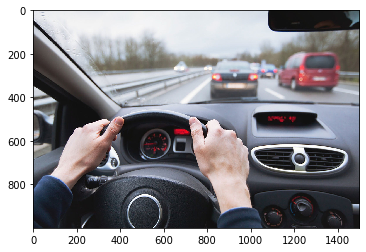

torch.Size([3, 1000, 1500])
[{'boxes': tensor([[107.8772, 494.2013, 412.5698, 781.5463],
        [717.8436, 496.5945, 986.8732, 825.1255]], device='cuda:0',
       grad_fn=<StackBackward>), 'labels': tensor([1, 1], device='cuda:0'), 'scores': tensor([0.9994, 0.9987], device='cuda:0', grad_fn=<IndexBackward>)}]


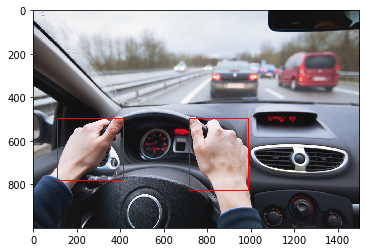

0.1542365550994873


In [21]:
import time
image = io.imread('testimg.jpg')
show_boxes(image, [], transpose=False)
prep = get_transform(False)
trans, _ = prep(image, _)
print(trans.shape)
model.eval()
trans_in = torch.stack([trans]).cuda()
t0 = time.time()
out = model(trans_in)
t1 = time.time()
print(out)
show_boxes(image, out[0]["boxes"], transpose=False)
print(t1-t0)

# (optional) load a pretrained model

In [0]:
%%shell
wget --save-cookies cookies.txt 'https://docs.google.com/uc?export=download&id=1l27wVs9Q-ztW5wVQVxi7QXDelZZLugoN' -O- \ | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1/p' > confirm_mod.txt
wget --load-cookies cookies.txt -O model_file \
     'https://docs.google.com/uc?export=download&id=1l27wVs9Q-ztW5wVQVxi7QXDelZZLugoN&confirm='$(<confirm_mod.txt)

In [20]:
checkpoint = torch.load('model_file') #if using cpu add map_location=torch.device('cpu'))
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>